In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

In [3]:
circuits = pd.read_csv("../data/circuits.csv")
constructors = pd.read_csv("../data/constructors.csv")
drivers = pd.read_csv("../data/drivers.csv")
qualification = pd.read_csv("../data/qualifying.csv")
races = pd.read_csv("../data/races.csv")
results = pd.read_csv("../data/results.csv")
seasons = pd.read_csv("../data/seasons.csv")

In [4]:
#merge files

dataframe_1 = pd.merge(drivers,qualification,how='inner', on=['driverId'])
dataframe_2 = pd.merge(dataframe_1, results, how="inner", on =["driverId", "raceId", "constructorId"])
dataframe_3 = pd.merge(dataframe_2, constructors, how="inner", on=["constructorId"])
dataframe_4 = pd.merge(dataframe_3, races, how="inner", on=['raceId'])
dataframe_5 = pd.merge(dataframe_4, circuits, how="inner", on=["circuitId"])

C:\Users\Nidup\AppData\Local\Temp\ipykernel_36900\1740145850.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'url_x'} in the result is deprecated and will raise a MergeError in a future version.
  dataframe_5 = pd.merge(dataframe_4, circuits, how="inner", on=["circuitId"])


In [5]:
# print(dataframe_5.columns)
final_data = dataframe_5.drop(['number_x','url_x', 'qualifyId', 
       'number_y', 'q1', 'q2', 'q3', 'position_y', 'positionText', 'positionOrder', 
       'time_x', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'url_y', 'name_y', 'time_y', 'url_x',
       'lat', 'lng', 'alt', 'url_y'],axis=1)

In [6]:

final_data.rename(columns={'name':'GP_name','position_x':'position','name_x':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
# final_data.to_csv("data_merged.csv")

In [7]:
print(final_data.columns)
#changing the names of the constructors who have changed their team names
final_data['constructor'] = final_data['constructor'].apply(lambda x: 'Astin Martin' if x=='Force India' or x=="Racing Point" else x)
final_data['constructor'] = final_data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='BMW Sauber' else x)
final_data['constructor'] = final_data['constructor'].apply(lambda x: 'Alpine' if x=='Lotus F1' or x=="Renault" else x)
final_data['constructor'] = final_data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)
# print(final_data["constructor"].unique())

Index(['driverId', 'driverRef', 'code', 'forename', 'surname', 'dob',
       'driver_nationality', 'raceId', 'constructorId', 'position', 'resultId',
       'number', 'grid', 'points', 'laps', 'statusId', 'constructorRef',
       'constructor', 'constructor_nationality', 'year', 'round', 'circuitId',
       'date', 'circuitRef', 'GP_name', 'location', 'country'],
      dtype='object')


In [8]:
#Driver name
final_data["driver"] = final_data["forename"] + final_data["surname"]

In [9]:
#Calculating the age of driver during the race
final_data["dob"] = pd.to_datetime(final_data["dob"])
final_data["date"] = pd.to_datetime(final_data["date"])
final_data["ageDuringRace"] = abs(final_data["dob"] - final_data["date"])
final_data["ageDuringRace"] = final_data["ageDuringRace"].apply(lambda x: str(x).split(" ")[0])
final_data["ageDuringRace"] = final_data["ageDuringRace"].astype("int64") #changing to int type


C:\Users\Nidup\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16/03/2008' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Nidup\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '18/03/2007' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Nidup\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '29/03/2009' in DD/MM/YYYY format. Provide format or spec

In [10]:
age_vs_points = final_data[['driver', 'ageDuringRace', 'points']].copy()
age_vs_points.isnull().sum()
age_vs_points.dropna(inplace=True)
#converting to age
age_vs_points["ageDuringRace"] = age_vs_points["ageDuringRace"].apply(lambda age: age//365)

In [11]:
# exporting the age and points for all the drivers 
#  age_vs_points.to_csv("age_vs_points.csv")


In [12]:
age_vs_points = pd.read_csv("age_vs_points.csv")
#summing up all the points for a particular age
age = age_vs_points.ageDuringRace.unique()
points = []
for i in age:
    points.append(age_vs_points[age_vs_points["ageDuringRace"] == i].points.sum())

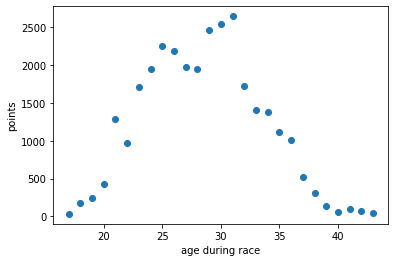

In [13]:
#correlation between age and points won during a race
x = age
y = points
plt.scatter(x, y)
plt.xlabel('age during race')
plt.ylabel("points")
plt.show()

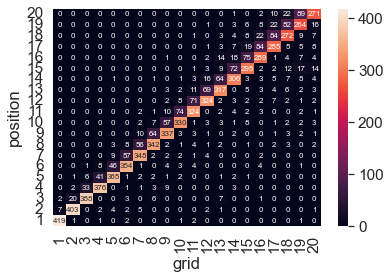

In [14]:
#1 correlation pole position vs wining the race
pole_vs_win = final_data[["grid", "position"]].copy()

#pruning the data
pole_vs_win = pole_vs_win[pole_vs_win["position"] <= 20]
pole_vs_win = pole_vs_win[(pole_vs_win["grid"] > 0) &(pole_vs_win["grid"] <= 20)]
pole_vs_win.dropna(inplace=True)

x = pole_vs_win["position"]
y = pole_vs_win["grid"]

cf_matrix = confusion_matrix(x, y)
# print(cf_matrix)
cf_matrix = pd.crosstab(x, y)
dc_cm = pd.DataFrame(cf_matrix)
sn.set(font_scale=1.4)
# plt.figure(figsize=(20,20))
sn.heatmap(dc_cm, annot=True, fmt="g", annot_kws={"size": 8}, xticklabels=True, yticklabels=True)
plt.gca().invert_yaxis()
plt.show()


In [15]:
def home_nationality(nat):
    if nat == 'German':
        return 'Germany'
    elif nat == 'British':
        return 'UK'
    elif nat == 'Spanish':
        return 'Spain'
    elif nat == 'French':
        return 'France'
    elif nat == 'Russian':
        return 'Russia'
    elif nat == 'Mexican':
        return 'Mexico'
    elif nat == 'Brazilian':
        return 'Brazil'
    elif nat == 'Japanese':
        return 'Japan'
    elif nat == 'Australian':
        return 'Australia'
    elif nat == 'Dutch':
        return 'Austria'
    elif nat == 'Belgian':
        return 'Belgium'
    elif nat == 'Italian':
        return 'Italy'
    elif nat == 'Canadian':
        return 'Canada'
    elif nat == 'Monegasque':
        return 'Monaco'
    elif nat == 'American':
        return 'USA'
    elif nat == "Finnish":
        return "Finland"
    elif nat == "Polish":
        return "Poland"
    elif nat == "Austrian":
        return "Austrai"
    elif nat == "Swiss":
        return "Switzerland"
    elif nat == "Danish":
        return "Denmark"
    else:
        return np.nan


In [16]:
def driver_nation_filter(country):
    driver_nations = ['Germany', 'Denmark', 'UK', 'Spain', 'Finland', 'France',
                      'Russia', 'Mexico', 'Venezuela', 'Sweden', 'Brazil',
                      'Japan', 'Australia', 'Austria', 'Indonesia', 'Belgium',
                      'Italy', 'Canada', 'New Zealand', 'Monaco', 'Thailand',
                      'Poland', 'USA']
    if country in driver_nations:
        return country
    else:
        return np.nan

In [29]:
#2 correlation: home advantage for drivers
home_race = final_data[["country", "driver_nationality", "points"]].copy()
home_race.dropna(inplace=True)
home_race["driver_nation"] = home_race.driver_nationality.apply(home_nationality)
home_race.country = home_race.country.apply(driver_nation_filter)
home_race.dropna(inplace=True)

In [73]:
home_mean_points = home_race.groupby(['country', 'driver_nationality']).mean()
home_mean_points.sort_values(by=['country', 'points'], ascending=[True, False]).head(30)





points
country   driver_nationality           
Australia Monegasque           5.000000
          Spanish              4.464286
          British              4.435897
          German               4.329412
          Finnish              4.190476
          Polish               3.600000
          Australian           3.500000
          Danish               3.250000
          Dutch                2.615385
          Brazilian            2.269231
          Russian              2.222222
          Swiss                1.500000
          Canadian             1.454545
          Austrian             1.076923
          Italian              1.045455
          Mexican              1.000000
          French               0.756757
          Belgian              0.500000
          Japanese             0.500000
          American             0.000000
Austria   Dutch               12.636364
          Finnish              9.000000
          Monegasque           8.000000
          British              6.941176
          German               4.838710
          Mexican              4.833333
          Australian           3.818182
          Spanish              3.111111
          Brazilian            2.916667
          Danish               2.285714

#3 correlation

In [ ]:
print(final_data.columns)

Index(['driverId', 'driverRef', 'code', 'forename', 'surname', 'dob',
       'driver_nationality', 'raceId', 'constructorId', 'position', 'resultId',
       'number', 'grid', 'points', 'laps', 'statusId', 'constructorRef',
       'constructor', 'constructor_nationality', 'year', 'round', 'circuitId',
       'date', 'circuitRef', 'GP_name', 'location', 'country', 'driver',
       'ageDuringRace', 'Drivers'],
      dtype='object')


In [ ]:
#scraping data for driver's height 

#Python program to scrape website 
#and save quotes from website
import requests
from bs4 import BeautifulSoup
import csv
   
URL = "https://racingnews365.com/2022-f1-drivers-height-and-weight"
r = requests.get(URL)
   
soup = BeautifulSoup(r.content, 'html.parser')
table_body = soup.findChildren("tbody")
print(table_body)
for row in table_body:
    cells = row